In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import ast

In [9]:
def load_and_visualize_csv(directory, file_names, columns_to_visualize, experiment_labels=None):
    # Initialize a list to store the averages for each file
    averages = []

    # Use file_names as default labels if experiment_labels is not provided or mismatched
    if experiment_labels is None or len(experiment_labels) != len(file_names):
        experiment_labels = file_names

    # Iterate through the specified file names
    for file_name in file_names:
        # Construct the full file path
        file_path = os.path.join(directory, file_name + ".csv")
        
        # Load the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)
        
        # Calculate the average for the specified columns
        averages_dict = df[columns_to_visualize].mean().to_dict()
        averages_dict['Experiment'] = file_name
        
        # Append the results to the list
        averages.append(averages_dict)
    
    # Create a new DataFrame from the averages list
    averages_df = pd.DataFrame(averages)
    
    # Define the position of the bars on the X-axis
    num_columns = len(columns_to_visualize)
    num_experiments = len(file_names)
    bar_width = 0.8 / num_experiments  # Adjust the width so bars don't overlap
    
    # Create a numpy array for the X-axis positions
    indices = np.arange(num_columns)
    
    # Plot each experiment's data side by side for each attribute
    plt.figure(figsize=(6, 4))
    for i, experiment in enumerate(averages_df['Experiment']):
        plt.bar(indices + i * bar_width, averages_df.loc[i, columns_to_visualize], 
                width=bar_width, label=experiment_labels[i])
    
    # Set the labels and title
    plt.xlabel('Attribute')
    plt.ylabel('Average Value')
    plt.title('Average Values by Attribute and Experiment')
    
    # Set the x-ticks to the middle of each group of bars
    plt.xticks(indices + bar_width * (num_experiments - 1) / 2, columns_to_visualize)
    
    # Add a legend
    plt.legend(title='Experiment')
    
    # Display the plot
    plt.show()

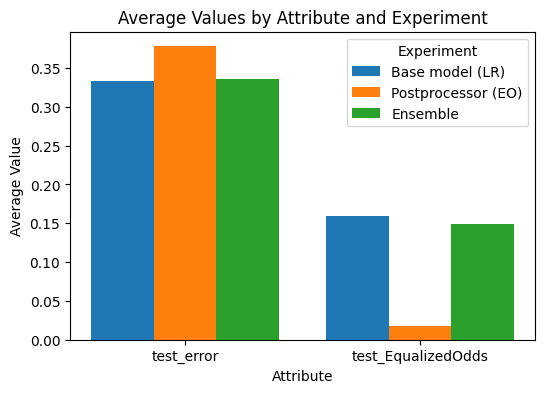

In [30]:
directory = r'C:\Users\m.pirrelli\Downloads\fairnesseval-main\demo_results\e10\compas'  # Update this with your directory path
file_names = ['e10_compas_lr_compas', 'e10_compas_eo_compas_lr', 'e10_compas_ensemble_compas_lr']
experiment_names = ['Base model (LR)', 'Postprocessor (EO)', 'Ensemble']
columns_to_visualize = ['test_error', 'test_EqualizedOdds']  # Specify the columns to visualize

load_and_visualize_csv(directory, file_names, columns_to_visualize, experiment_labels=experiment_names)

In [20]:
def load_and_visualize_csv_by_phase(directory, file_names, columns_to_visualize, experiment_labels=None):
    # Initialize a list to store the averages for each file, grouped by phase
    averages = []

    # Use file_names as default labels if experiment_labels is not provided or mismatched
    if experiment_labels is None or len(experiment_labels) != len(file_names):
        experiment_labels = file_names

    # Iterate through the specified file names
    for file_name in file_names:
        # Construct the full file path
        file_path = os.path.join(directory, file_name + ".csv")
        
        # Load the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)
        
        # Ensure that 'phase' is a column in the CSV file
        if 'phase' not in df.columns:
            raise ValueError(f"File {file_name}.csv must contain a 'phase' column with 'train' or 'evaluation' values.")

        # Calculate the average for the specified columns, grouped by phase
        for phase in ['train', 'evaluation']:
            phase_df = df[df['phase'] == phase]
            if not phase_df.empty:
                averages_dict = phase_df[columns_to_visualize].mean().to_dict()
                averages_dict['Experiment'] = file_name
                averages_dict['Phase'] = phase
                averages.append(averages_dict)
    
    # Create a new DataFrame from the averages list
    averages_df = pd.DataFrame(averages)
    
    # Define the position of the bars on the X-axis
    num_columns = len(columns_to_visualize)
    num_experiments = len(file_names)
    num_phases = 2  # Train and Evaluation
    bar_width = 0.8 / num_phases  # Adjust the width so train and evaluation bars don't overlap
    
    # Create a numpy array for the X-axis positions
    indices = np.arange(num_experiments)
    
    # Plot the data, with separate bars for 'train' and 'evaluation' for each experiment
    plt.figure(figsize=(6, 4))
    
    for i, column in enumerate(columns_to_visualize):
        # Offset the bars for 'train' and 'evaluation' within each experiment group
        for j, phase in enumerate(['train', 'evaluation']):
            # Filter the averages_df for the current column and phase
            subset = averages_df[(averages_df['Phase'] == phase)]
            bar_positions = indices + j * bar_width + bar_width/2  # Shift for 'train' and 'evaluation'
            
            # Plot the bars for the current column and phase
            plt.bar(bar_positions + i * (num_phases * bar_width), 
                    subset[column].values, 
                    width=bar_width, 
                    label=f"{column} ({phase.capitalize()})" if i == 0 else "")
    
    # Set the labels and title
    plt.xlabel('Experiment')
    plt.ylabel('Average Value')
    plt.title('Average Values by Attribute, Phase, and Experiment')
    
    # Set the x-ticks to the middle of each group of bars
    plt.xticks(indices + bar_width * num_phases / 2, experiment_labels)
    
    # Add a legend
    plt.legend(title='Attribute (Phase)')
    
    # Display the plot
    plt.show()


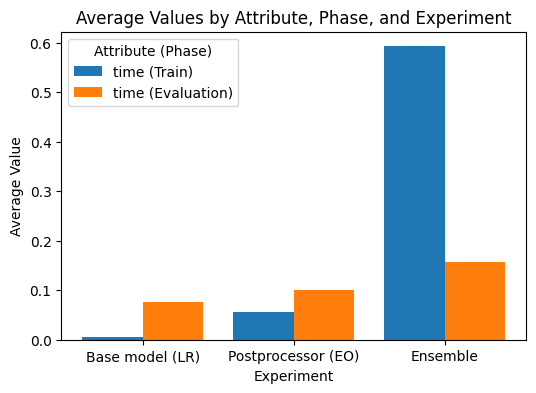

In [31]:
load_and_visualize_csv_by_phase(directory, file_names, ['time'], experiment_labels=experiment_names)

In [28]:
def load_and_plot_fairness_metrics(directory, file_names, experiment_labels=None):
    # Initialize a dictionary to store the fairness metrics for each experiment
    fairness_metrics = {}

    # Use file_names as default labels if experiment_labels is not provided or mismatched
    if experiment_labels is None or len(experiment_labels) != len(file_names):
        experiment_labels = file_names

    # Iterate through the specified file names
    for i, file_name in enumerate(file_names):
        # Construct the full file path
        file_path = os.path.join(directory, file_name + ".csv")
        
        # Load the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)
        
        # Ensure that 'model_fairness_metrics' is a column in the CSV file
        if 'model_fairness_metrics' not in df.columns:
            raise ValueError(f"File {file_name}.csv must contain a 'model_fairness_metrics' column.")

        # Extract the 'model_fairness_metrics' column and convert it from a string to a list of floats
        metrics_str = df['model_fairness_metrics'].iloc[0]
        metrics_list = ast.literal_eval(metrics_str)  # Convert the string to a list of floats

        # Store the metrics in the dictionary
        fairness_metrics[experiment_labels[i]] = metrics_list
    
    # Plot the fairness metrics for each experiment
    plt.figure(figsize=(6, 4))
    
    for label, metrics in fairness_metrics.items():
        plt.plot(metrics, label=label)  # Plot each experiment's metrics with a different color
    
    # Set the labels and title
    plt.xlabel('Metric Index')
    plt.ylabel('Fairness Metric Value')
    plt.title('Model Fairness Metrics Across Experiments')
    
    max_length = max(len(metrics) for metrics in fairness_metrics.values())
    plt.xticks(range(max_length))
    
    # Add a legend to identify the experiments
    plt.legend(title='Experiment')
    
    # Display the plot
    plt.show()

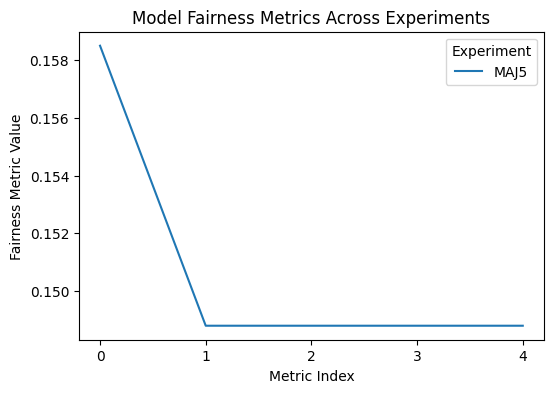

In [32]:
load_and_plot_fairness_metrics(directory, ["e10_compas_ensemble_compas_lr"], ["MAJ5"])

In [1]:
def compute_metrics_stats(directory, file_names, metrics):
    # Initialize a list to store the statistics for each file
    stats_list = []

    # Iterate through the specified file names
    for file_name in file_names:
        # Construct the full file path
        file_path = os.path.join(directory, file_name + ".csv")
        
        # Load the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)
        
        # Ensure the specified metrics exist in the DataFrame
        for metric in metrics:
            if metric not in df.columns:
                raise ValueError(f"File {file_name}.csv must contain the '{metric}' column.")

        # Calculate the mean and standard deviation for each metric
        stats_dict = {'Experiment': file_name}
        for metric in metrics:
            stats_dict[f'{metric}_mean'] = df[metric].mean()
            stats_dict[f'{metric}_std'] = df[metric].std()
        
        # Append the stats to the list
        stats_list.append(stats_dict)
    
    # Create a DataFrame from the stats list
    stats_df = pd.DataFrame(stats_list)
    
    return stats_df

In [7]:
directory = r'C:\Users\m.pirrelli\Downloads\fairnesseval-main\demo_results\e14\e14_compas'  # Update this with your directory path
file_names = ['e14_compas_expgrad_compas_lr', 'e14_compas_feld_compas_lr', 'e14_compas_hardt_compas_lr', 'e14_compas_zafareo_compas_lr','e14_compas_ensemble']
columns_to_visualize = ['train_error', 'train_EqualizedOdds', 'test_error', 'test_EqualizedOdds']  # Specify the columns to visualize

compute_metrics_stats(directory, file_names, columns_to_visualize)

,Experiment,train_error_mean,train_error_std,train_EqualizedOdds_mean,train_EqualizedOdds_std,test_error_mean,test_error_std,test_EqualizedOdds_mean,test_EqualizedOdds_std
0,e14_compas_expgrad_compas_lr,0.447913,0.008834,0.005000,3.795321e-16,0.452474,0.009335,0.029666,0.011976
1,e14_compas_feld_compas_lr,0.356811,0.001409,0.251603,1.096233e-02,0.356953,0.002710,0.252518,0.016610
2,e14_compas_hardt_compas_lr,0.376800,0.003860,0.005552,3.821306e-03,0.376611,0.006321,0.020772,0.010940
3,e14_compas_zafareo_compas_lr,0.357477,0.033611,0.141917,4.253828e-02,0.361639,0.031296,0.141246,0.042522
4,e14_compas_ensemble,0.367398,0.006114,0.107637,8.942938e-03,0.368558,0.006867,0.109966,0.019764
